In [2]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, RepeatVector, TimeDistributed
#from keras.datasets import imdb
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model
#import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

In [6]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
mat_contents = sio.loadmat('peipei.mat')
x = mat_contents['x']
y = mat_contents['y']

x_train = x[0:150,:,:]
y_train = y[0:150,:,:]

x_test = x[150:173,:,:]
y_test = y[150:173,:,:]

# get dimensions
m, nt, npitch = x_train.shape
ny = y_train.shape[2]
print('m ,nt, npitch = ', str(x_train.shape))
print('ny = ' + str(ny))
print(y_train.shape)

Loading data...
m ,nt, npitch =  (150, 100, 176)
ny = 443
(150, 100, 443)


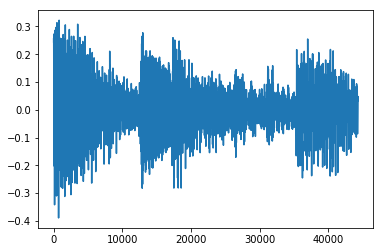

In [7]:
y_vec = y_train[5,:,:].reshape((nt*ny,1))
plt.plot(y_vec)

In [8]:
def bidi_LSTM(m, nt, npitch, ny):
    # define bidirectional LSTM configuration
    n_neurons_encoder = 128 # refers to size of Memory matrices (can be anything)
    #n_neurons_decoder = 10
    #intermediate_layer = 500;

    # create LSTM
    model = Sequential()
    # encoder
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),input_shape=(nt, npitch)))
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (n_neurons_encoder, n_neurons_encoder)))
    #model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (nbatch,n_neurons_encoder,n_neurons_encoder)))
    model.add(TimeDistributed(Dense(ny, activation=None)))
    
#     model.add(RepeatVector(intermediate_layer))
#     # decoder
#     model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(ny/2,n_neurons_decoder)))
#     model.add(Bidirectional(LSTM(n_neurons_decoder)))
#     model.add(RepeatVector(ny))
#     model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(ny,n_neurons_decoder)))
#     model.add(TimeDistributed(Dense(1)))

    return model

In [9]:
model = bidi_LSTM(m, nt, npitch, ny)
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100, 256)          312320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 443)          113851    
Total params: 820,411
Trainable params: 820,411
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
#print(model.summary())
# train LSTM
nbatch = 10
nepoch = 100
model.fit(x_train, y_train, epochs=nepoch, batch_size=nbatch)
# evaluate

Epoch 1/100
150/150 [==============================] - 8s 50ms/step - loss: 0.0027
Epoch 2/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0026
Epoch 3/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0026
Epoch 4/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0025
Epoch 5/100
150/150 [==============================] - 7s 49ms/step - loss: 0.0026
Epoch 6/100
150/150 [==============================] - 7s 49ms/step - loss: 0.0026
Epoch 7/100
150/150 [==============================] - 8s 50ms/step - loss: 0.0027
Epoch 8/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0030
Epoch 9/100
150/150 [==============================] - 7s 50ms/step - loss: 0.0029
Epoch 10/100
150/150 [==============================] - 7s 49ms/step - loss: 0.0028
Epoch 11/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0027
Epoch 12/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0028
E

150/150 [==============================] - 7s 49ms/step - loss: 0.0021
Epoch 99/100
150/150 [==============================] - 8s 51ms/step - loss: 0.0021
Epoch 100/100
150/150 [==============================] - 7s 49ms/step - loss: 0.0021


In [49]:

from scipy.io.wavfile import write

y_train_flattened = y_train.reshape(y_train.size,1)
scaled = np.int16(y_train_flattened/np.max(np.abs(y_train_flattened))*32767)
write('y_train.mp3',44100,scaled)

y_test_flattened = y_test.reshape(y_test.size,1)
scaled = np.int16(y_test_flattened/np.max(np.abs(y_test_flattened))*32767)
write('y_test.mp3',44100,scaled)

# evaluate train
y_pred_train = model.predict(x_train, batch_size=nbatch)

y_pred_flattened = y_pred_train.reshape(y_pred_train.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred.mp3',44100,scaled)

# evaluate test
y_pred_test = model.predict(x_test, batch_size=nbatch)

y_pred_flattened = y_pred.reshape(y_pred_test.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred_test.mp3',44100,scaled)

sio.savemat('y_train.mat',mdict={'y_train':y_train})
sio.savemat('y_pred_train.mat',mdict={'y_pred_train': y_pred_train})
#print(result)

nmodel = 1
filepath = 'models/run' + str(nmodel)
model.save(filepath)

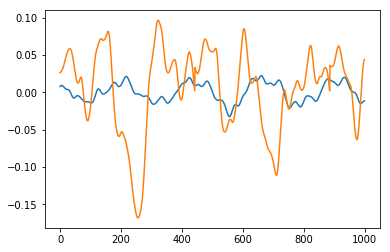

In [54]:
#print(result.shape)
y_train_vec = y_test[20,:,:].reshape((nt*ny,1))
y_pred_vec = y_pred_test[20,:,:].reshape((nt*ny,1))

plt.figure(1)
plt.plot(y_train_vec[0:1000])
plt.plot(y_pred_vec[0:1000])

<function matplotlib.pyplot.show>

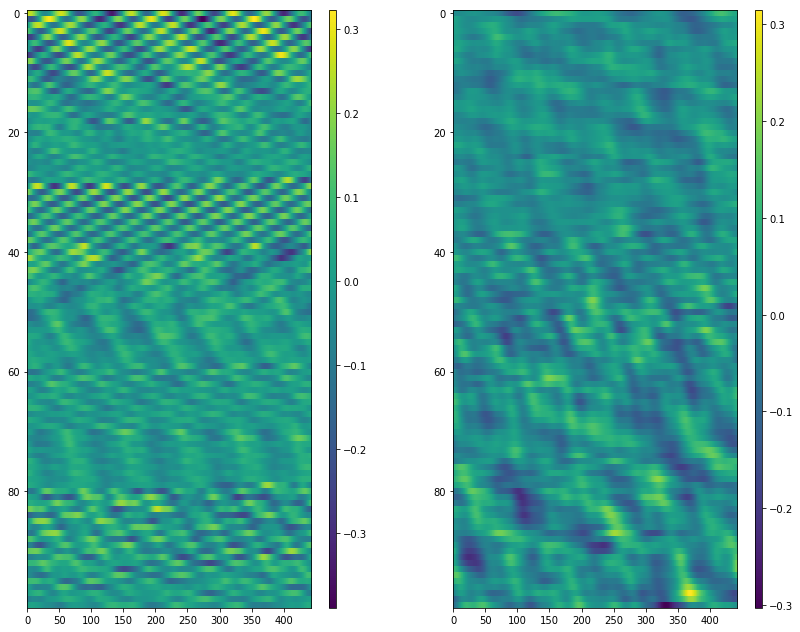

In [51]:
plt.figure(figsize=(14,11))
plt.subplot(1,2,1)
plt.imshow(y_train[5,:,:], aspect='auto')
a = plt.colorbar(aspect=80)
# fig.add_subplot(1,2,1)
plt.subplot(1,2,2)
plt.imshow(y_pred[5,:,:], aspect='auto')
a = plt.colorbar(aspect=80)
plt.show

In [ ]:
print(np.sum((result.flatten()-Y_train.flatten())**2)/44100)
print(result.flatten()[10:15])